(time-cont-scale-notebook)=
# Il tempo su una metrica continua

Quando si cerca di comprendere il cambiamento all’interno della persona, una prima decisione importante è quella di scegliere una scala temporale appropriata per monitorare il cambiamento. Ad esempio, nell’esempio illustrativo discusso nel capitolo precedente, abbiamo scelto il grado scolastico come scala temporale e abbiamo organizzato le osservazioni attorno a questa metrica. Tuttavia, questa non è l’unica metrica del tempo possibile per questi dati. Altre metriche potenzialmente significative includono l’età e l’occasione di misurazione. Esistono metriche del tempo che rappresentano intervalli di tempo discreti, come l’occasione di misurazione o il grado scolastico, dove la metrica assume valori discreti comuni ai partecipanti. Ma non tutti i partecipanti devono essere valutati in ogni occasione di misurazione. Esistono anche metriche del tempo più continue, come l’età, dove i valori non sono comuni a più partecipanti. La stessa metrica può essere utilizzata in modo discreto o continuo. Ad esempio, l’età potrebbe essere arrotondata all’anno più vicino e il grado scolastico potrebbe essere misurato con precisione come anno scolastico più i giorni dall’inizio dell’anno. In questo capitolo discutiamo tecniche per adattare modelli di crescita con una metrica del tempo continua.

## Una applicazione concreta

L’approccio della finestra temporale è un metodo potenziale per analizzare dati con occasioni di misurazione individualmente variabili. In sostanza, l’approccio della finestra temporale mira ad approssimare la metrica del tempo individualmente variabile su una scala discreta. Ad esempio, ciò può essere ottenuto arrotondando il tempo/l’età al mezzo o al quarto d’anno più vicino.

Questo metodo è ovviamente ancora un’approssimazione del tempo. Si può ottenere maggiore precisione utilizzando finestre più piccole, ma se la matrice dei dati diventa troppo sparsa, la stima diventa difficile.

In questo esempio, le finestre temporali sono definite come semestri. Quindi, prendiamo i nostri dati in formato long, arrotondiamo l’età al semestre più vicino e convertiamo i dati in formato wide per l’utilizzo nel framework SEM.

In [1]:
source("_common.R")
suppressPackageStartupMessages({
    library("lavaan")
    library("semPlot")
    library("knitr")
    library("markdown")
    library("patchwork")
    library("psych")
    library("DT")
    library("kableExtra")
    library("lme4")
})

set.seed(42)

ERROR: Error in bayesplot::theme_default(size = 12, family = "sans"): unused arguments (size = 12, family = "sans")


Per questo esempio considereremo i dati di presrtazione matematica dal data set NLSY-CYA Long Data [si veda {cite:t}`grimm2016growth`]. Iniziamo a leggere i dati.

In [2]:
#set filepath for data file
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_long_R.dat"
#read in the text data file using the url() function
dat <- read.table(file=url(filepath),
                  na.strings = ".")  #indicates the missing data designator
#copy data with new name 
nlsy_math_long <- dat  

#Add names the columns of the data set
names(nlsy_math_long) = c('id'     , 'female', 'lb_wght', 
                          'anti_k1', 'math'  , 'grade'  ,
                          'occ'    , 'age'   , 'men'    ,
                          'spring' , 'anti')

#subset to the variables of interest
nlsy_math_long <- nlsy_math_long[ ,c("id", "math", "grade", "age")]
#view the first few observations in the data set 
head(nlsy_math_long, 10)

,id,math,grade,age
,<int>,<int>,<int>,<int>
1,201,38,3,111
2,201,55,5,135
3,303,26,2,121
4,303,33,5,145
5,2702,56,2,100
6,2702,58,4,125
7,2702,80,8,173
8,4303,41,3,115
9,4303,58,4,135


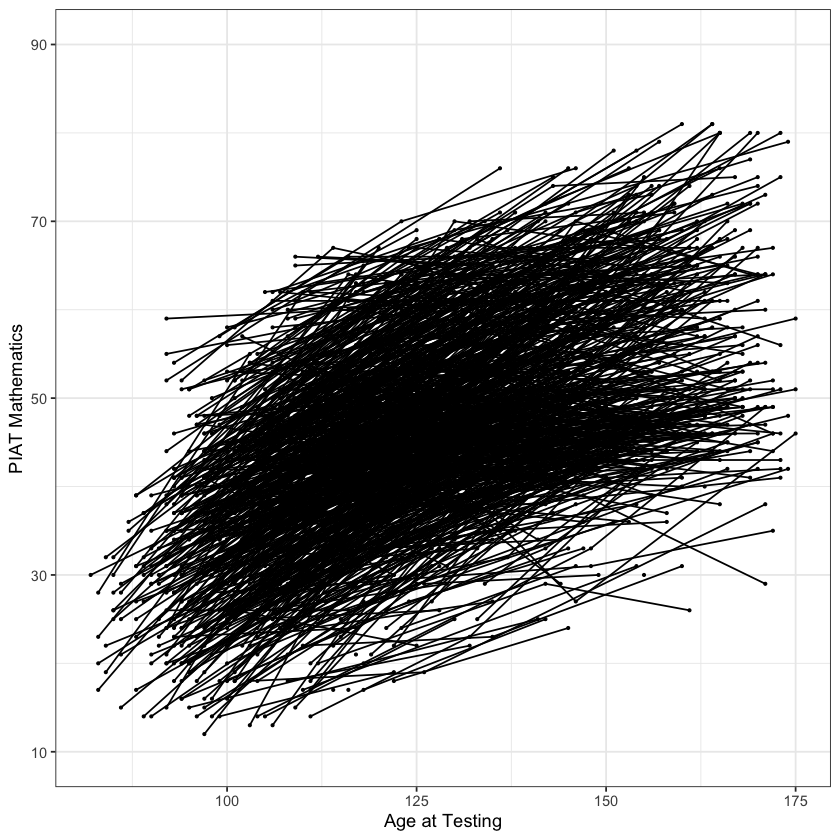

In [3]:
#intraindividual change trajetories
ggplot(data=nlsy_math_long,                    #data set
       aes(x = age, y = math, group = id)) + #setting variables
  geom_point(size=.5) + #adding points to plot
  geom_line() +  #adding lines to plot
  theme_bw() +   #changing style/background
  #setting the x-axis with breaks and labels
  scale_x_continuous(#limits=c(2,8),
                     #breaks = c(2,3,4,5,6,7,8), 
                     name = "Age at Testing") +    
  #setting the y-axis with limits breaks and labels
  scale_y_continuous(limits=c(10,90), 
                     breaks = c(10,30,50,70,90), 
                     name = "PIAT Mathematics")

 Implementiamo il metodo della finestra temporale e ricodifichiamo i dati in formato wide.

In [4]:
# creating new age variable scaled in years
nlsy_math_long$ageyr <- (nlsy_math_long$age / 12)
head(nlsy_math_long)

,id,math,grade,age,ageyr
,<int>,<int>,<int>,<int>,<dbl>
1,201,38,3,111,9.250000
2,201,55,5,135,11.250000
3,303,26,2,121,10.083333
4,303,33,5,145,12.083333
5,2702,56,2,100,8.333333
6,2702,58,4,125,10.416667


In [5]:
# rounding to nearest half-year
# multiplied by 10 to remove decimal for easy conversion to wide
nlsy_math_long$agewindow <- plyr::round_any(nlsy_math_long$ageyr * 10, 5)
head(nlsy_math_long)

,id,math,grade,age,ageyr,agewindow
,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,201,38,3,111,9.250000,90
2,201,55,5,135,11.250000,110
3,303,26,2,121,10.083333,100
4,303,33,5,145,12.083333,120
5,2702,56,2,100,8.333333,85
6,2702,58,4,125,10.416667,105


In [6]:
# reshaping long to wide (just variables of interest)
nlsy_math_wide <- reshape(
  data = nlsy_math_long[, c("id", "math", "agewindow")],
  timevar = c("agewindow"),
  idvar = c("id"),
  v.names = c("math"),
  direction = "wide", sep = ""
)

# reordering columns for easy viewing
nlsy_math_wide <- nlsy_math_wide[, c(
  "id", "math70", "math75", "math80", "math85", "math90", "math95", "math100", "math105", "math110", "math115", "math120", "math125", "math130", "math135", "math140", "math145"
)]
# looking at the data
head(nlsy_math_wide)

,id,math70,math75,math80,math85,math90,math95,math100,math105,math110,math115,math120,math125,math130,math135,math140,math145
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,201,NA,NA,NA,NA,38,NA,NA,NA,55,NA,NA,NA,NA,NA,NA,NA
3,303,NA,NA,NA,NA,NA,NA,26,NA,NA,NA,33,NA,NA,NA,NA,NA
5,2702,NA,NA,NA,56,NA,NA,NA,58,NA,NA,NA,NA,NA,NA,NA,80
8,4303,NA,NA,NA,NA,NA,41,NA,NA,58,NA,NA,NA,NA,NA,NA,NA
10,5002,NA,NA,NA,NA,NA,NA,46,NA,NA,NA,54,NA,NA,NA,66,NA
13,5005,NA,NA,35,NA,NA,50,NA,NA,NA,60,NA,NA,NA,59,NA,NA


Specifichiamo il modello SEM.

In [7]:
#writing out linear growth model in full SEM way 
lg_math_age_lavaan_model <- '
  # latent variable definitions
      #intercept (note intercept is a reserved term)
      eta_1 =~  1*math70 +
                1*math75 +
                1*math80 +
                1*math85 +
                1*math90 +
                1*math95 +
                1*math100 +
                1*math105 +
                1*math110 +
                1*math115 +
                1*math120 +
                1*math125 +
                1*math130 +
                1*math135 +
                1*math140 +
                1*math145 

      #linear slope (note intercept is a reserved term)
      eta_2 =~ -1*math70 +
               -0.5*math75 +
                0*math80 +
                0.5*math85 +
                1*math90 +
                1.5*math95 +
                2*math100 +
                2.5*math105 +
                3*math110 +
                3.5*math115 +
                4*math120 +
                4.5*math125 +
                5*math130 +
                5.5*math135 +
                6*math140 +
                6.5*math145

  # factor variances
      eta_1 ~~ start(65)*eta_1
      eta_2 ~~ start(.75)*eta_2

  # covariances among factors 
      eta_1 ~~ start(1.2)*eta_2

  # manifest variances (made equivalent by naming theta)
      math70 ~~ start(35)*theta*math70
      math75 ~~ theta*math75
      math80 ~~ theta*math80
      math85 ~~ theta*math85
      math90 ~~ theta*math90
      math95 ~~ theta*math95
      math100 ~~ theta*math100
      math105 ~~ theta*math105
      math110 ~~ theta*math110
      math115 ~~ theta*math115
      math120 ~~ theta*math120
      math125 ~~ theta*math125
      math130 ~~ theta*math130
      math135 ~~ theta*math135
      math140 ~~ theta*math140
      math145 ~~ theta*math145
      
  # manifest means (fixed at zero)
      math70 ~ 0*1
      math75 ~ 0*1
      math80 ~ 0*1
      math85 ~ 0*1
      math90 ~ 0*1
      math95 ~ 0*1
      math100 ~ 0*1
      math105 ~ 0*1
      math110 ~ 0*1
      math115 ~ 0*1
      math120 ~ 0*1
      math125 ~ 0*1
      math130 ~ 0*1
      math135 ~ 0*1
      math140 ~ 0*1
      math145 ~ 0*1

  # factor means (estimated freely)
      eta_1 ~ start(35)*1
      eta_2 ~ start(4)*1
' #end of model definition

Adattiamo il modello ai dati.

In [8]:
#estimating the model using sem() function
lg_math_age_lavaan_fit <- sem(lg_math_age_lavaan_model,
  data = nlsy_math_wide,
  meanstructure = TRUE,
  estimator = "ML",
  missing = "fiml"
)

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have 0%
    coverage; use lavInspect(fit, "coverage") to investigate.”
Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Esaminiamo la soluzione.

In [ ]:
summary(lg_math_age_lavaan_fit, fit.measures = TRUE) |>
    print()

In [ ]:
parameterEstimates(lg_math_age_lavaan_fit) |>
    print()

In [ ]:
inspect(lg_math_age_lavaan_fit, what="est") |>
    print()

Creiamo un diagramma di percorso.

In [ ]:
semPaths(lg_math_age_lavaan_fit,what = "path", whatLabels = "par")